In [1]:
from __future__ import unicode_literals, print_function, division
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from scipy import sparse

from io import open
import unicodedata
import string, time, random

Automatically created module for IPython interactive environment


In [2]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):    
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    ys = np.zeros(len(lines))
    names = []
    for i,line in enumerate(lines):
        nn = line.split(' ')
        ys[i] = int(nn[-1])
        names.append(' '.join(unicodeToAscii(c) for c in nn[:-1]).lower())
    return names, ys.astype(int)

In [3]:
def loadNames(data_fname):
    all_names, labels = readLines(data_fname)
    labels -= 1  # encode labels from 0 instead of 1

    C = ''.join(sorted({l for word in all_names for l in word}))  # all characters in all_names
    d_char = len(C)  # dimension of the one-hot vector to encode each character 
    lab_name, count_lab = np.unique(labels, return_counts=True)
    K = len(lab_name)  # the number of classes
    name_len = max([len(name) for name in all_names])  # dimension the one-hot vector to encode each name
    N = len(all_names)
    
    # Encode input to training and validation set
    MNames = namesToMatrix(C, all_names, name_len)
    Y = np.zeros((K,N))
    Y[labels,np.arange(len(labels))] = 1
    val_ind = np.genfromtxt('Validation_Inds.txt').astype(int)-1
    ind = np.ones(N, dtype=bool)
    ind[val_ind] = False
    
    XVa = MNames[:,val_ind]
    YVa = Y[:,val_ind]
    labelsVa = labels[val_ind]
    
    XTr = MNames[:,ind]
    YTr = Y[:,ind]
    labelsTr = labels[ind]
    
    reweight = (1/(K*count_lab)).reshape(-1,1)
    labels_name = np.genfromtxt('category_labels.txt')
    
    return XTr, YTr, labelsTr, XVa, YVa, labelsVa, reweight, C


def letterToIndex(C,letter):
    return C.find(letter)   # can use all_letters instead of C (the n_letters instead of d) for the general case

def lineToTensor(C, line, name_len):
    d_char = len(C)
    if len(line)>name_len:
        line = line[:name_len]
    tensor = np.zeros((d_char, name_len))
    for li, letter in enumerate(line):
        tensor[letterToIndex(C,letter)][li] = 1
    return tensor

def namesToMatrix(C, names, name_len):
    N = len(names)
    d_char = len(C)
    X = np.zeros((d_char*name_len,N))
    for i,name in enumerate(names):
        X[:,[i]] = lineToTensor(C,name,name_len).T.reshape(-1,1)
    return X

def readCategory():
    lines = open('category_labels.txt', encoding='utf-8').read().strip().split('\n')
    category = {}
    for line in lines:
        nn = line.split(' ')
        category[int(nn[0])-1] = (' '.join(unicodeToAscii(c) for c in nn[1:]))
    return category

In [4]:
def plot_confusion_matrix(y_true,y_pred,classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          save_name=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    if save_name is not None:
        fig.savefig('Figures/ConfusionMatrix'+save_name+'.pdf')
    return ax

def plotResults(x,y,name='loss',save_name=None):
    fig = plt.figure()
    plt.plot(x,y[0],label='training '+name)
    plt.plot(x,y[1],label='validation '+name)
    plt.legend(loc=0)
    plt.xlabel('n_epoch')
    plt.ylabel(name)
    if save_name is not None:
        fig.savefig('Figures/'+name+'_params'+save_name+'.pdf')
    plt.show()

In [5]:
class ConvNetwork:

    def __init__(self, **kwargs):
        """
        Initialize Convolution Neural Network with data and parameters
        """

        var_defaults = {
            "eta": 0.001,  # learning rate
            "n_batch": 100,  # size of data batches within an epoch
            "rho": 0.9,  # momentum term
        }

        for var, default in var_defaults.items():
            setattr(self, var, kwargs.get(var, default))

        self.W = None
        self.F = None
        self.loss_train_history = []
        self.loss_val_history = []
    
    def init_sets(self, net_structure):
        """
        Initialize a weight matrix of output nodes (k) x features (d) and the filter matrices
        """
        self.F = []
        len_net = len(net_structure)-1
        for i in range(len_net):
            self.F.append(np.random.normal(0,net_structure[i]['std'],net_structure[i]['filter']))

        # Initialize weight matrix classes x features
        self.W = np.random.normal(0,net_structure[len_net]['std'],net_structure[len_net]['weight'])
        
    def train(self,net_structure,X,Y,y,dx,n_epochs=100,shuf=False,verbose=False,
              show_plot=False,imbalance=False,momentum=False,save_name='0'):
        """
        dx - the dimension of a character
        """
        X_train = X[0]
        Y_train = Y[0]
        y_train = y[0]
        X_val = X[1]
        Y_val = Y[1]
        y_val = y[1]
    
        d,n = X_train.shape
        K = Y_train.shape[0]
        nlen = int(d/dx)
        
        self.init_sets(net_structure)
        numBatches = int(np.floor(n/self.n_batch))
        
        if imbalance:
            y_unique, count_yu = np.unique(y_train, return_counts=True)
            yu_min = min(count_yu)
            X_imba = X_train[:]
            Y_imba = Y_train[:]
            y_imba = y_train[:]
        
        if momentum:
            momentW = np.zeros(self.W.shape)
            momentF = []
            for Fi in self.F:
                momentF.append(np.zeros(Fi.shape))
        
        self.loss_train_history = np.zeros(n_epochs)
        self.loss_val_history = np.zeros(n_epochs)
        
        acc_train_epoch = np.zeros(n_epochs)
        acc_val_epoch = np.zeros(n_epochs)
            
        for i in range(n_epochs):
            loss_train = 0  # total loss
            acc_train = 0
            if imbalance:
                permute = list(range(n))
                random.shuffle(permute)
                permute = np.array(permute)
                ind_permute = permute[np.hstack(np.where(y_imba[permute]==i)[0][:yu_min] for i in range(K))]
                X_train = X_imba[:,ind_permute]
                Y_train = Y_imba[:,ind_permute]
                y_train = y_imba[ind_permute]
                numBatches = int(np.floor(X_train.shape[1]/self.n_batch))
                
            if shuf:
                permute = list(range(len(y_train)))
                random.shuffle(permute)
                X_train = X_train[:,permute]
                Y_train = Y_train[:,permute]
                y_train = y_train[permute]
                
            XBatch,YBatch,yBatch = self.generateBatches(X_train,Y_train,y_train)
                
            for j in range(numBatches):
                xTr = XBatch[:,:,j]
                yTr = YBatch[:,:,j]
                ys = yBatch[:,j]
                grad_w, grad_f, loss, y_pred = self.backward(xTr, yTr)
                               
                if momentum:  # update weight with momentum
                    momentW = self.rho*momentW + self.eta*grad_w
                    self.W = self.W - momentW
                    for ii in range(len(self.F)):
                        momentF[ii] = self.rho*momentF[ii] + self.eta*grad_f[ii]
                        self.F[ii] = self.F[ii] - momentF[ii]
                else:                
                    # update the weights without momentum
                    self.W = self.W - self.eta*grad_w
                    for ii in range(len(self.F)):
                        self.F[ii] = self.F[ii] - self.eta*grad_f[ii]
                loss_train += loss
                acc_train += self.computeAccuracy(ys,y_pred)
                
            self.loss_train_history[i] = loss_train/(numBatches+0.0)
            acc_train_epoch[i] = acc_train/(numBatches+0.0)
        
            if verbose or show_plot:
                self.loss_val_history[i], acc_val_epoch[i], yval_pred = self.test(X_val,Y_val,y_val)
                
            if verbose and (10*(i+1))%n_epochs==0:  # print after 10% of training process           
                print("Epoch: {} - Training Accuracy: {}% Loss: {} Validation Accuracy: {}%".format(i, round(acc_train_epoch[i]*100,2), 
                                                                           self.loss_train_history[i], round(acc_val_epoch[i]*100,2)))
                
        if show_plot:
            plot_confusion_matrix(y_val, yval_pred, 
                                  classes=np.arange(1,Y_val.shape[0]+1),save_name=save_name)
            plotResults(np.arange(n_epochs),[self.loss_train_history, self.loss_val_history],
                        name='loss',save_name=save_name) 
            plotResults(np.arange(n_epochs),[acc_train_epoch, acc_val_epoch],
                        name='accuracy',save_name=save_name) 
            plt.show()
            print("The final Validation Accuracy: {}%".format(round(acc_val_epoch[-1]*100,2)))

    
    def test(self,X,Y,y):
        X_,P,y_pred = self.forward(X)
        loss = self.computeLoss(X,Y,P)
        acc = self.computeAccuracy(y,y_pred)
        return loss, acc, y_pred
    
    def forward(self,X_batch):
        X = [] 
        X_in = X_batch[:]
        for i in range(len(self.F)):
            nlen = int(X_in.shape[0]/self.F[i].shape[0])
            MF = self.makeMFMatrix(i,nlen) 
            X_in = self.ReLu(np.dot(MF,X_in))
            X.append(X_in[:])
        P = self.SoftMax(np.dot(self.W,X_in)) 
        y_pred = np.argmax(P, axis=0)
        return X,P,y_pred

    def backward(self,X_batch,Y_batch):
        dx,nx = X_batch.shape
    
        grad_F = []
        for i in range(len(self.F)):
            grad_F.append(np.zeros((1,np.prod(self.F[i].shape))))
    
        X,P_batch,y_pred = self.forward(X_batch)
        loss = self.computeLoss(X_batch, Y_batch, P_batch)
        G_batch = P_batch-Y_batch
        
        grad_W = np.dot(G_batch, X[-1].T)/float(nx)
    
        M_f = self.W[:]
        for i in reversed(range(1,len(self.F))):
            d_f,k_f,n_f = self.F[i].shape
            G_batch = np.dot(M_f.T,G_batch)
           
            G_batch = G_batch*(X[i]>0)
       
            dx,nx = X[i-1].shape
            for j in range(nx):
                x = X[i-1][:,j]
                mx = self.makeMXMatrix(x,d_f,k_f,1)
                g_ma = G_batch[:,[j]].reshape(-1,n_f)               
                v = np.dot(mx.T,g_ma).T.reshape(1,-1)
                #v = np.dot(G_batch[:,[j]].T,self.makeMXMatrix(x,d_f,k_f,n_f))
                grad_F[i] += v/float(nx)
            
            nlen = int(dx/d_f)
            M_f = self.makeMFMatrix(i,nlen)
            grad_F[i] = grad_F[i].reshape((n_f,k_f,d_f)).T
        
        # layer 1
        d_f,k_f,n_f = self.F[0].shape
        G_batch = np.dot(M_f.T,G_batch)
           
        G_batch = G_batch*(X[0]>0)
                
        dx,nx = X_batch.shape
        for j in range(nx):
            x = X_batch[:,j]
            #v = self.makeMXMatrix_sparse(x,d_f,k_f,n_f).transpose().dot(G_batch[:,[j]]).T
            v = self.makeMXMatrix(x,d_f,k_f,n_f).transpose().dot(G_batch[:,[j]]).T
            grad_F[0] = grad_F[0] + v/float(nx)
            
        nlen = int(dx/d_f)
        M_f = self.makeMFMatrix(0,nlen)
        grad_F[0] = grad_F[0].reshape((n_f,k_f,d_f)).T
    
        return grad_W, grad_F, loss, y_pred
    
    def ReLu(self,s):
        return np.maximum(0,s)

    def SoftMax(self,s):
        p = np.exp(s)/np.expand_dims(np.exp(s).sum(axis=0),axis=0)  # matrix of size KxN
        return p
    
    def makeMFMatrix(self,ind_fil,ncol):
        """
        F[ind_fil] has the same row to X that means size of F is (d x k x nf) and 
        ncol>k which is the number of column of the input
        """
        fil = self.F[ind_fil]
        dd,kk,n_filter = fil.shape
        M_filter = np.zeros((n_filter*(ncol-kk+1),dd*ncol))
        F_vec = fil[:].T.reshape(n_filter,-1)
        for i in range(ncol-kk+1):
            M_filter[i*n_filter:(i+1)*n_filter,i*dd:F_vec.shape[1]+i*dd] = F_vec
        return M_filter

    def makeMXMatrix(self,x_input,d,k,nf):
        nlen = int(x_input.shape[0]/d)
        MX = np.zeros((nf*(nlen-k+1),k*nf*d))
        if nf==1:
            for i in range(nlen-k+1):
                MX[i*nf:(i+1)*nf,:] = x_input[i*d:(i+k)*d]
        else:
            for i in range(nlen-k+1):
                MX[i*nf:(i+1)*nf,:] = np.kron(np.eye(nf),x_input[i*d:(i+k)*d])
        return MX
    
    
    def makeMXMatrix_sparse(x_input,d,k,nf):
        nlen = int(x_input.shape[0]/d)   
        nr = nf*(nlen-k+1)
        nc = k*nf*d
        MX = sparse.lil_matrix((nr,nc))
        ind_no = np.nonzero(x_input)[0]         
        for i in ind_no:
            r = i//d
            c = i%d
            for j in range(min(k,r+1,nlen-r)):
                MX[np.arange(nf)*r+j,np.arange(nf)+c] = x_input[i]
        return MX  

    
    def computeAccuracy(self,labels,y_pred):
        acc = np.sum(labels==y_pred)/(len(labels)+0.0)
        return acc

    def computeLoss(self,X, Y, P):
        loss = np.sum(-np.log(np.diag(np.dot(Y.T,P))))/(X.shape[1]+0.0)
        return loss

    def generateBatches(self,X,Y,y):
        d,n = X.shape
        K = Y.shape[0]
        XBatch = np.zeros((d,self.n_batch,int(n/self.n_batch)))
        YBatch = np.zeros((K,self.n_batch,int(n/self.n_batch)))
        yBatch = np.zeros((self.n_batch,int(n/self.n_batch)))
    
        for i in range(int(n/self.n_batch)):
            i_start = i*self.n_batch
            i_end = (i+1)*self.n_batch
            XBatch[:,:,i] = X[:,i_start:i_end]
            YBatch[:,:,i] = Y[:,i_start:i_end]
            yBatch[:,i] = y[i_start:i_end]
        return XBatch, YBatch, yBatch
    
    def NumericalGradient(self, X, Y, h):
        grad_W = np.zeros(self.W.shape)
        grad_F = []
        for l in range(len(self.F)):  
            Fk = self.F[l]
            grad_Fk = np.zeros(Fk.shape)
            for k in range(Fk.shape[2]):
                for j in range(Fk.shape[1]):
                    for i in range(Fk.shape[0]):
                        Fk[i,j,k] -= h
                        X_,P,y_pred = self.forward(X)
                        l1 = self.computeLoss(X, Y, P)
                    
                        Fk[i,j,k] += 2*h                    
                        X_,P,y_pred = self.forward(X)
                        l2 = self.computeLoss(X, Y, P)
                    
                        grad_Fk[i,j,k] = (l2-l1)/(2*h)
                        Fk[i,j,k] -= h
            grad_F.append(grad_Fk)
        
        # compute the gradient for the fully connected layer
        for j in range(self.W.shape[1]):
            for i in range(self.W.shape[0]):
                self.W[i,j] -= h
                X_,P,y_pred = self.forward(X)
                l1 = self.computeLoss(X, Y, P)
            
                self.W[i,j] += 2*h
                X_,P,y_pred = self.forward(X)
                l2 = self.computeLoss(X, Y, P)
            
                grad_W[i,j] = (l2-l1)/(2*h)
                self.W[i,j] -= h
            
        return grad_W, grad_F

    # Check gradient computation
    def checkGrads(self, X, Y, reweight, h=1e-6):
        eps = 1e-30
        error = 1e-6
    
        gW1,gF1 = self.NumericalGradient(X,Y,h)
        gW2,gF2,l_,y_ = self.backward(X,Y)
           
        error_w = np.abs(gW1-gW2)/np.maximum(eps,np.abs(gW1)+np.abs(gW2))
        print('The number of error (relative error > 1e-6) of W:', np.sum(error_w>error))
        print('The maximum of relative error of W:', np.max(error_w))

        total_error_f = 0
    
        for i in range(len(self.F)):
            error_f = np.abs(gF1[i]-gF2[i])/np.maximum(eps,np.abs(gF1[i])+np.abs(gF2[i]))
            total_error_f += np.sum(error_f>error)
            max_f = np.max(error_f)        
            print('The number of errors (relative error > 1e-6) of filter {}: {}'.format(i,total_error_f))
            print('The maximum of relative error of filter {}: {}'.format(i,max_f))

## 1. Read in the data and get it ready

In [6]:
data_fname = 'ascii_names.txt'
XTr, YTr, yTr, XVa, YVa, yVa, reweight, total_char = loadNames(data_fname)
d_char = len(total_char)

category = readCategory()  # dictinary of class names

In [7]:
print(d_char)

28


In [8]:
all_names, labels = readLines(data_fname)

In [14]:
print(max([len(name) for name in all_names]))
print(all_names[np.argmax([len(name) for name in all_names])])

19
shirinskyshikhmatov


## 2. Set hyper-parameter and initialize the ConvNet's parameters

In [19]:
nlen = int(XTr.shape[0]/d_char)
# filter layer 1
k1 = 5
n1 = 5
sig1 = np.sqrt(2./(10*k1))  # For the first layer where input is sparse d_char is set is 10
# filter layer 2
k2 = 5
n2 = 5
sig2 = np.sqrt(2./(n1*k2))
# weights
K = YTr.shape[0]
fsize = n2*(nlen-k1-k2+2)
sig3 = np.sqrt(2./fsize)

model_paras = {"eta": 0.001,  # learning rate
               "n_batch": 100,  # size of data batches within an epoch
               "rho": 0.9,  # momentum term
              }

net_struc = {0:{'std':sig1,'filter':[d_char,k1,n1]}, # filter 1
             1:{'std':sig2,'filter':[n1,k2,n2]},  # filter 2
             2:{'std':sig3,'weight':[K,fsize]}  # weights
            }  

net = ConvNetwork(**model_paras)
net.init_sets(net_struc)

## 3. Construct the convolution matrices

In [28]:
# debug MF and MX
x_input = XTr[:,:1]

dd,kk,nf = net.F[0].shape

s1 = np.dot(net.makeMXMatrix(x_input,dd,kk,nf), net.F[0].T.reshape(-1,1))
s2 = np.dot(net.makeMFMatrix(0,nlen), x_input)
print(np.sum(np.abs(s1-s2)>1e-100))

0


## 4. Implement the forward and backward pass of back-prop

In [44]:
# Numerical check for gradients
nlen = int(XTr.shape[0]/d_char)
# filter layer 1
k1 = 5
n1 = 5
sig1 = np.sqrt(2./(10*k1))  # For the first layer where input is sparse d_char is set is 10
# filter layer 2
k2 = 5
n2 = 5
sig2 = np.sqrt(2./(n1*k2))
# weights
K = YTr.shape[0]
fsize = n2*(nlen-k1-k2+2)
sig3 = np.sqrt(2./fsize)

model_paras = {"eta": 0.001,  # learning rate
               "n_batch": 1,  # size of data batches within an epoch
               "rho": 0.9,  # momentum term
              }

net_struc = {0:{'std':sig1,'filter':[d_char,k1,n1]}, # filter 1
             1:{'std':sig2,'filter':[n1,k2,n2]},  # filter 2
             2:{'std':sig3,'weight':[K,fsize]}  # weights
            }  

net = ConvNetwork(**model_paras)
net.init_sets(net_struc)
net.checkGrads(XTr[:,:6], YTr[:,:6], 1e-5)

The number of error (relative error > 1e-6) of W: 0
The maximum of relative error of W: 4.940123577024272e-07
The number of errors (relative error > 1e-6) of filter 0: 0
The maximum of relative error of filter 0: 7.582209070388632e-07
The number of errors (relative error > 1e-6) of filter 1: 0
The maximum of relative error of filter 1: 8.724810501754798e-07


In [45]:
model_paras = {"eta": 0.001,  # learning rate
               "n_batch": 2,  # size of data batches within an epoch
               "rho": 0.9,  # momentum term
              } 

net = ConvNetwork(**model_paras)
net.init_sets(net_struc)
net.checkGrads(XTr[:,:6], YTr[:,:6], 1e-5)

The number of error (relative error > 1e-6) of W: 2
The maximum of relative error of W: 2.9212056861892006e-06
The number of errors (relative error > 1e-6) of filter 0: 0
The maximum of relative error of filter 0: 2.9442325781691894e-07
The number of errors (relative error > 1e-6) of filter 1: 0
The maximum of relative error of filter 1: 3.92294992692926e-07


In [80]:
model_paras = {"eta": 0.001,  # learning rate
               "n_batch": 3,  # size of data batches within an epoch
               "rho": 0.9,  # momentum term
              } 

net = ConvNetwork(**model_paras)
net.init_sets(net_struc)
net.checkGrads(XTr[:,:6], YTr[:,:6], 1e-5)

The number of error (relative error > 1e-6) of W: 0
The maximum of relative error of W: 9.539478143083176e-07
The number of errors (relative error > 1e-6) of filter 0: 1
The maximum of relative error of filter 0: 4.672309403308377e-06
The number of errors (relative error > 1e-6) of filter 1: 1
The maximum of relative error of filter 1: 5.108455966805446e-07


### The efficient of extra measures

In [85]:
# Not Using the upgrade method
nlen = int(XTr.shape[0]/d_char)   # = 19
# filter layer 1
k1 = 5
n1 = 10
sig1 = np.sqrt(2./(10*k1))  # For the first layer where input is sparse d_char is set is 10
# filter layer 2
k2 = 3
n2 = 10
sig2 = np.sqrt(2./(n1*k2))
# weights
K = YTr.shape[0]
fsize = n2*(nlen-k1-k2+2)
sig3 = np.sqrt(2./fsize)

model_paras = {"eta": 0.001,  # learning rate
               "n_batch": 100,  # size of data batches within an epoch
               "rho": 0.9,  # momentum term
              }

net_struc = {0:{'std':sig1,'filter':[d_char,k1,n1]}, # filter 1, d_char = 28
             1:{'std':sig2,'filter':[n1,k2,n2]},  # filter 2
             2:{'std':sig3, 'weight':[K,fsize]}  # weights
            } 

net = ConvNetwork(**model_paras)
tic = time.time()
net.train(net_struc,[XTr,XVa],[YTr,YVa],[yTr,yVa],d_char,n_epochs=1,shuf=True,
          momentum=True)
toc = time.time()
print('Execution time: ',toc-tic)

Execution time:  50.5283682346344


In [15]:
# Using the upgrade method -> make comment for line 179 and uncomment for lines 176-178 (in backward pass)
nlen = int(XTr.shape[0]/d_char)
# filter layer 1
k1 = 5
n1 = 10
sig1 = np.sqrt(2./(10*k1))  # For the first layer where input is sparse d_char is set is 10
# filter layer 2
k2 = 3
n2 = 10
sig2 = np.sqrt(2./(n1*k2))
# weights
K = YTr.shape[0]
fsize = n2*(nlen-k1-k2+2)
sig3 = np.sqrt(2./fsize)

model_paras = {"eta": 0.001,  # learning rate
               "n_batch": 100,  # size of data batches within an epoch
               "rho": 0.9,  # momentum term
              }

net_struc = {0:{'std':sig1,'filter':[d_char,k1,n1]}, # filter 1
             1:{'std':sig2,'filter':[n1,k2,n2]},  # filter 2
             2:{'std':sig3, 'weight':[K,fsize]}  # weights
            }

net = ConvNetwork(**model_paras)
tic = time.time()
net.train(net_struc,[XTr,XVa],[YTr,YVa],[yTr,yVa],d_char,n_epochs=1,shuf=True,
          momentum=True)
toc = time.time()
print('Execution time: ',toc-tic)

Execution time:  33.711302042007446


## 5. Train using mini-batch gradient descent with momentum

Epoch: 0 - Training Accuracy: 40.14% Loss: 2.174973924054029 Validation Accuracy: 5.95%
Epoch: 15 - Training Accuracy: 62.09% Loss: 1.3159922870060923 Validation Accuracy: 13.89%
Epoch: 30 - Training Accuracy: 67.61% Loss: 1.1131024769539684 Validation Accuracy: 17.06%
Epoch: 45 - Training Accuracy: 70.77% Loss: 0.9982686819275871 Validation Accuracy: 21.83%
Epoch: 60 - Training Accuracy: 73.26% Loss: 0.918596530349604 Validation Accuracy: 24.6%
Epoch: 75 - Training Accuracy: 75.03% Loss: 0.8527099070777641 Validation Accuracy: 29.37%
Epoch: 90 - Training Accuracy: 76.49% Loss: 0.7985446921431112 Validation Accuracy: 29.37%
Epoch: 105 - Training Accuracy: 77.96% Loss: 0.7519751845805042 Validation Accuracy: 32.54%
Epoch: 120 - Training Accuracy: 79.1% Loss: 0.7139838922790799 Validation Accuracy: 34.92%
Epoch: 135 - Training Accuracy: 79.72% Loss: 0.6822009289203778 Validation Accuracy: 36.51%
Confusion matrix, without normalization
[[14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

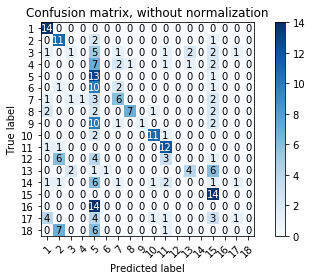

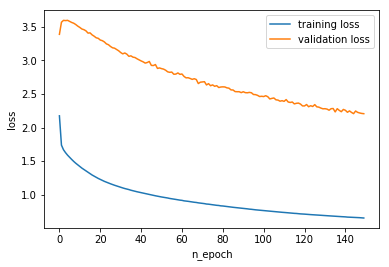

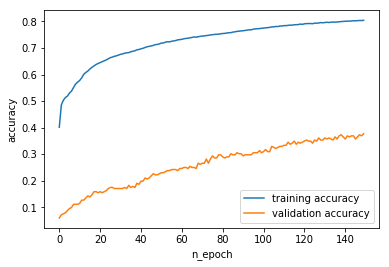

The final Validation Accuracy: 37.7%
Execution time:  17870.691295146942


In [61]:
# (2.iii) Train with > 20,000 updates without compensating for the unbalanced dataset
nlen = int(XTr.shape[0]/d_char)
# filter layer 1
k1 = 5
n1 = 20
sig1 = np.sqrt(2./(10*k1))  # For the first layer where input is sparse d_char is set is 10
# filter layer 2
k2 = 3
n2 = 20
sig2 = np.sqrt(2./(n1*k2))
# weights
K = YTr.shape[0]
fsize = n2*(nlen-k1-k2+2)
sig3 = np.sqrt(2./fsize)

model_paras = {"eta": 0.001,  # learning rate
               "n_batch": 100,  # size of data batches within an epoch
               "rho": 0.9,  # momentum term
              }

net_struc = {0:{'std':sig1,'filter':[d_char,k1,n1]}, # filter 1
             1:{'std':sig2,'filter':[n1,k2,n2]},  # filter 2
             2:{'std':sig3, 'weight':[K,fsize]}  # weights
            } 

net = ConvNetwork(**model_paras)
tic = time.time()
net.train(net_struc,[XTr,XVa],[YTr,YVa],[yTr,yVa],d_char,n_epochs=150,shuf=True,
          verbose=True,show_plot=True,momentum=True,save_name='unbalance')
toc = time.time()
print('Execution time: ',toc-tic)

Epoch: 199 - Training Accuracy: 32.96% Loss: 2.1949102034036625 Validation Accuracy: 28.17%
Epoch: 399 - Training Accuracy: 45.95% Loss: 1.6873337797980863 Validation Accuracy: 36.51%
Epoch: 599 - Training Accuracy: 51.79% Loss: 1.480132079683033 Validation Accuracy: 43.25%
Epoch: 799 - Training Accuracy: 56.4% Loss: 1.3113943401169454 Validation Accuracy: 47.22%
Epoch: 999 - Training Accuracy: 63.28% Loss: 1.194737868537648 Validation Accuracy: 48.41%
Epoch: 1199 - Training Accuracy: 62.62% Loss: 1.1093901545616065 Validation Accuracy: 50.0%
Epoch: 1399 - Training Accuracy: 68.93% Loss: 1.0303134512203556 Validation Accuracy: 50.4%
Epoch: 1599 - Training Accuracy: 70.53% Loss: 0.9456620692332032 Validation Accuracy: 50.79%
Epoch: 1799 - Training Accuracy: 72.79% Loss: 0.8756056524301317 Validation Accuracy: 51.59%
Epoch: 1999 - Training Accuracy: 76.18% Loss: 0.7748262380064894 Validation Accuracy: 52.78%
Confusion matrix, without normalization
[[13  1  0  0  0  0  0  0  0  0  0  0  0

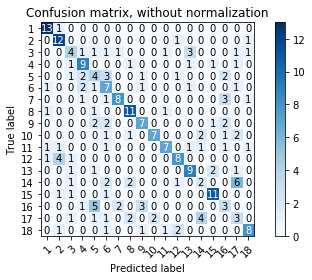

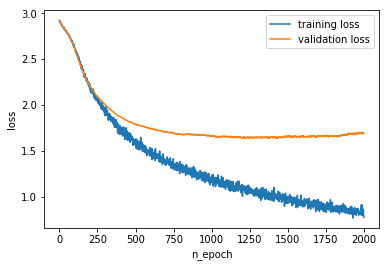

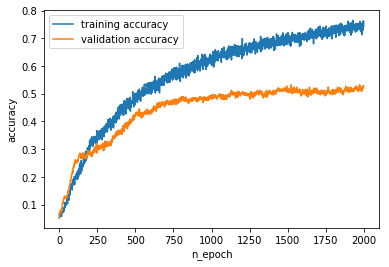

The final Validation Accuracy: 52.78%
Execution time:  17416.59308075905


In [90]:
# Train with 20,000 updates with compensating for the unbalanced dataset
nlen = int(XTr.shape[0]/d_char)
# filter layer 1
k1 = 5
n1 = 20
sig1 = np.sqrt(2./(10*k1))  # For the first layer where input is sparse d_char is set is 10
# filter layer 2
k2 = 3
n2 = 20
sig2 = np.sqrt(2./(n1*k2))
# weights
K = YTr.shape[0]
fsize = n2*(nlen-k1-k2+2)
sig3 = np.sqrt(2./fsize)

model_paras = {"eta": 0.001,  # learning rate
               "n_batch": 59,  # size of data batches within an epoch
               "rho": 0.9,  # momentum term
              }

net_struc = {0:{'std':sig1,'filter':[d_char,k1,n1]}, # filter 1
             1:{'std':sig2,'filter':[n1,k2,n2]},  # filter 2
             2:{'std':sig3, 'weight':[K,fsize]}  # weights
            } 

net = ConvNetwork(**model_paras)
tic = time.time()
net.train(net_struc,[XTr,XVa],[YTr,YVa],[yTr,yVa],d_char,n_epochs=2000,shuf=True,
          verbose=True,show_plot=True,imbalance=True,momentum=True,save_name='balance')
toc = time.time()
print('Execution time: ',toc-tic)

## Accuracy for each class of the best performance

In [103]:
nlen = int(XTr.shape[0]/d_char)
# filter layer 1
k1 = 5
n1 = 20
sig1 = np.sqrt(2./(10*k1))  # For the first layer where input is sparse d_char is set is 10
# filter layer 2
k2 = 3
n2 = 50
sig2 = np.sqrt(2./(n1*k2))
# weights
K = YTr.shape[0]
fsize = n2*(nlen-k1-k2+2)
sig3 = np.sqrt(2./fsize)

model_paras = {"eta": 0.001,  # learning rate
               "n_batch": 59,  # size of data batches within an epoch
               "rho": 0.9,  # momentum term
              }

net_struc = {0:{'std':sig1,'filter':[d_char,k1,n1]}, # filter 1
             1:{'std':sig2,'filter':[n1,k2,n2]},  # filter 2
             2:{'std':sig3, 'weight':[K,fsize]}  # weights
            } 

net = ConvNetwork(**model_paras)
tic = time.time()
net.train(net_struc,[XTr,XVa],[YTr,YVa],[yTr,yVa],d_char,n_epochs=2500,shuf=True,
          imbalance=True,momentum=True,save_name='best')
toc = time.time()
print('Execution time: ',toc-tic)

Execution time:  16071.032768011093


Confusion matrix, without normalization
[[14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  4  1  0  0  1  0  1  1  1  0  3  0  1  0  0  1]
 [ 0  0  2  9  0  1  0  1  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  1  5  3  1  0  1  0  0  1  0  0  0  2  0  0]
 [ 0  0  1  1  3  2  0  1  2  0  0  0  1  0  1  0  2  0]
 [ 0  0  0  2  2  0  8  0  1  0  0  0  0  1  0  0  0  0]
 [ 1  0  0  0  1  1  0  7  0  1  1  0  0  0  1  0  1  0]
 [ 1  0  1  0  0  0  0  0  9  0  0  0  0  0  0  3  0  0]
 [ 1  0  0  0  0  1  0  1  0  7  0  0  0  3  0  0  1  0]
 [ 1  1  0  1  0  0  0  0  0  0 11  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  1  0  0  0  0  9  0  0  1  0  0  0]
 [ 0  0  4  0  0  0  0  0  0  0  1  0  6  0  3  0  0  0]
 [ 0  0  1  0  0  0  0  1  0  1  0  0  0  2  0  1  8  0]
 [ 0  0  1  0  0  0  1  0  0  0  0  1  0  0 11  0  0  0]
 [ 0  0  0  1  5  0  1  0  1  0  0  0  0  0  0  4  2  0]
 [ 0  0  0  1  1  0  0  1  0  2  1  0  0  3  1  

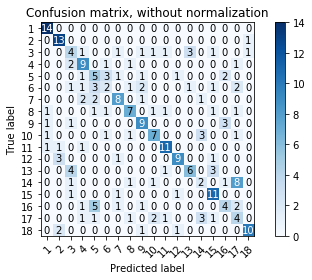

The final Validation Accuracy: 53.57%


In [105]:
loss,acc,y_pred = net.test(XVa,YVa,yVa)
plot_confusion_matrix(yVa, y_pred, classes=np.arange(1,YVa.shape[0]+1),save_name='best') 
plt.show()
print("The final Validation Accuracy: {}%".format(round(acc*100,2)))

In [106]:
lossTr,accTr,yTr_pred = net.test(XTr,YTr,yTr)
print(accTr)

0.7564400444489342


In [107]:
cm = confusion_matrix(yVa, y_pred)
class_prob = cm.diagonal()/np.sum(cm,axis=1)  
print(class_prob)

[1.         0.92857143 0.28571429 0.64285714 0.35714286 0.14285714
 0.57142857 0.5        0.64285714 0.5        0.78571429 0.64285714
 0.42857143 0.14285714 0.78571429 0.28571429 0.28571429 0.71428571]


In [16]:
nlen = int(XTr.shape[0]/d_char)
# filter layer 1
k1 = 5
n1 = 20
sig1 = np.sqrt(2./(10*k1))  # For the first layer where input is sparse d_char is set is 10
# filter layer 2
k2 = 3
n2 = 50
sig2 = np.sqrt(2./(n1*k2))
# weights
K = YTr.shape[0]
fsize = n2*(nlen-k1-k2+2)
sig3 = np.sqrt(2./fsize)

model_paras = {"eta": 0.001,  # learning rate
               "n_batch": 59,  # size of data batches within an epoch
               "rho": 0.9,  # momentum term
              }

net_struc = {0:{'std':sig1,'filter':[d_char,k1,n1]}, # filter 1
             1:{'std':sig2,'filter':[n1,k2,n2]},  # filter 2
             2:{'std':sig3, 'weight':[K,fsize]}  # weights
            } 

net = ConvNetwork(**model_paras)
tic = time.time()
net.train(net_struc,[XTr,XVa],[YTr,YVa],[yTr,yVa],d_char,n_epochs=3000,shuf=True,
          imbalance=True,momentum=True,save_name='best')
toc = time.time()
print('Execution time: ',toc-tic)

Execution time:  18565.851701021194


Confusion matrix, without normalization
[[14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 1  0  5  1  1  0  2  0  0  1  0  0  2  1  0  0  0  0]
 [ 0  0  2  7  1  1  1  1  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  6  2  0  0  2  0  0  1  0  0  0  2  0  0]
 [ 0  0  1  0  2  5  2  0  1  0  0  0  1  0  0  0  2  0]
 [ 1  0  0  1  1  0 10  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  0 10  0  1  0  0  0  0  0  0  1  0]
 [ 0  0  1  0  0  1  1  0  8  0  0  0  0  0  0  3  0  0]
 [ 1  0  0  0  0  0  1  1  0  6  0  0  0  2  0  0  3  0]
 [ 0  1  0  0  0  1  0  0  0  0 12  0  0  0  0  0  0  0]
 [ 1  4  1  0  0  0  0  0  0  0  0  8  0  0  0  0  0  0]
 [ 0  0  3  0  1  0  0  0  0  0  0  0  8  0  2  0  0  0]
 [ 0  0  0  0  1  0  1  1  0  0  0  0  0  2  0  0  9  0]
 [ 0  1  0  0  0  1  1  0  0  0  0  0  0  0 11  0  0  0]
 [ 0  0  1  0  5  0  2  0  0  0  0  0  0  0  0  3  3  0]
 [ 0  0  0  0  1  0  0  2  0  1  1  0  0  3  1  

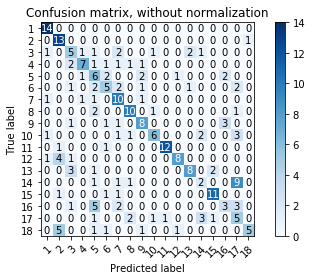

The final Validation Accuracy: 54.76%


In [41]:
loss,acc,y_pred = net.test(XVa,YVa,yVa)
plot_confusion_matrix(yVa, y_pred, classes=np.arange(1,YVa.shape[0]+1),save_name='best') 
plt.show()
print("The final Validation Accuracy: {}%".format(round(acc*100,2)))

In [42]:
print(loss)

1.9845778755245218


In [19]:
lossTr,accTr,yTr_pred = net.test(XTr,YTr,yTr)

In [40]:
print(accTr)
print(lossTr)

0.7428528134154965
0.8562449158324085


In [44]:
cm = confusion_matrix(yVa, y_pred)
class_prob = cm.diagonal()/np.sum(cm,axis=1)  
print(class_prob.round(4))

[1.     0.9286 0.3571 0.5    0.4286 0.3571 0.7143 0.7143 0.5714 0.4286
 0.8571 0.5714 0.5714 0.1429 0.7857 0.2143 0.3571 0.3571]


In [45]:
print(category.values())

dict_values(['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese'])


### Test with new data

In [23]:
name_test = ['Nguyen','Herrera','Martinez','Bergstrom','Batakis','Fontbona']
name_encode = namesToMatrix(total_char, name_test, nlen)
X_,P,y_pred = net.forward(name_encode)
for i,yi in enumerate(y_pred):
    print(name_test[i]+": "+category[yi]) 

Nguyen: Vietnamese
Herrera: Spanish
Martinez: Spanish
Bergstrom: English
Batakis: Greek
Fontbona: Italian


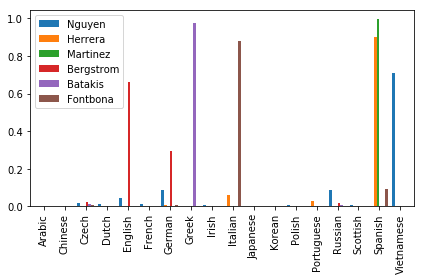

In [33]:
df = pd.DataFrame(data=P, columns=name_test, index=list(category.values()))
ax = df.plot.bar(width=0.8)
ax.legend(loc='best')
plt.tight_layout()
plt.savefig('Figures/proba_test.pdf')

In [38]:
print(df)

                  Nguyen       Herrera      Martinez     Bergstrom  \
Arabic      1.755429e-06  2.935361e-09  1.103962e-14  1.517484e-13   
Chinese     1.248380e-07  2.353268e-12  2.736419e-13  4.095259e-13   
Czech       2.085217e-02  2.527341e-03  7.830945e-06  2.509641e-02   
Dutch       1.450255e-02  1.549228e-03  1.830929e-06  5.618185e-05   
English     4.312408e-02  1.441998e-03  6.285375e-06  6.603984e-01   
French      1.233186e-02  4.406504e-05  3.524951e-05  2.216746e-03   
German      8.490800e-02  5.443868e-03  3.511246e-05  2.939586e-01   
Greek       1.373575e-04  7.943437e-08  2.299047e-09  6.665894e-06   
Irish       6.915342e-03  2.448532e-05  6.913226e-08  5.308482e-05   
Italian     1.002758e-05  5.933148e-02  4.303584e-03  5.937652e-06   
Japanese    4.430237e-05  3.654550e-07  5.195473e-08  3.957482e-08   
Korean      9.428184e-06  1.280309e-14  3.886511e-18  8.328527e-17   
Polish      5.652116e-03  3.442742e-03  2.327683e-07  1.003469e-05   
Portuguese  1.613348

### Sparse matrix run slower than numpy and they are not the same

In [17]:
%timeit x1 = makeMXMatrix_sparse(XTr[:,0],d_char,5,5)
%timeit x2 = makeMXMatrix(XTr[:,0],d_char,5,5)

1.51 ms ± 5.46 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
590 µs ± 2.14 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


[0 1 2 3]
Confusion matrix, without normalization
[[1 0 1 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 0 1 1]]


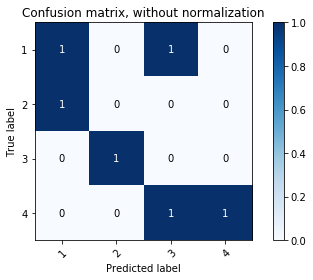

In [55]:
y_true = [0, 1, 0, 3, 2, 3]
y_pred = [0, 0, 2, 3, 1, 2]
print(unique_labels(y_true, y_pred))
plot_confusion_matrix(y_true, y_pred, classes=np.arange(1,5), save_name='test')

In [216]:
lab_name, count_lab = np.unique(yTr, return_counts=True)
print(lab_name)
print(count_lab)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
[1986  254  505  283 3654  263  710  189  218  695  977   80  125   60
 9370   86  284   59]


In [219]:
print(min(count_lab))
print(max(count_lab))

59
9370


In [221]:
print(d_char, nlen)
print(XTr.shape)

28 19
(532, 19798)
